This notebook takes the <b> "model2_inputdata.csv" </b> file generated from pre-processing step and uses it to create Machine learning model for bounce detection

In [1]:
import mlflow.tensorflow
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import sklearn
import re, numpy as np, tensorflow as tf
from keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# ground truth is 95 bounces.

from numpy.random import seed
seed(10)
tf.random.set_seed(10)

df = pd.read_csv("model2_inputdata.csv", header=None)
df.columns = ['file_name', 'top_left_x', 'top_left_y', 'width', 'height']

In [3]:
df.head()

,file_name,top_left_x,top_left_y,width,height
0,image1.txt,0.4216,0.4996,0.0091,0.0148
1,image2.txt,0.4233,0.4812,0.0083,0.0158
2,image3.txt,0.4249,0.4632,0.0088,0.0148
3,image4.txt,0.4259,0.4551,0.0096,0.0149
4,image5.txt,0.4277,0.4402,0.0094,0.0148


In [4]:
def id_extractor(image_name):
    return int(re.findall('\d+', image_name)[0])

In [5]:
df['image_id'] = df['file_name'].apply(id_extractor)
df['label'] = 0
df.head()

,file_name,top_left_x,top_left_y,width,height,image_id,label
0,image1.txt,0.4216,0.4996,0.0091,0.0148,1,0
1,image2.txt,0.4233,0.4812,0.0083,0.0158,2,0
2,image3.txt,0.4249,0.4632,0.0088,0.0148,3,0
3,image4.txt,0.4259,0.4551,0.0096,0.0149,4,0
4,image5.txt,0.4277,0.4402,0.0094,0.0148,5,0


In [6]:
ground_truth_bounce_frames = [36, 85, 126, 178, 415, 466, 504, 553, 592, 668, 947, 1000, 1054, 1135, 1312, 1557, 1600,
                              1651, 1721, 1973, 2016, 2052, 2095, 2140, 2180, 2221, 2269, 2315, 2354, 2399, 2442, 2493,
                              2535, 2574, 2615, 2658, 2700, 2738, 2774, 2825, 2862, 3080, 3115, 3164, 3202,
                              3249, 3311, 3373, 3416, 3697, 3742, 3787, 3828, 3873, 3907, 3954, 3986, 4227, 4277, 4318,
                              4361, 4402, 4446, 4499, 4531, 4580, 4610, 4673, 4732, 4767, 4801, 4846, 4890, 4931, 4964,
                              5024, 5241, 5283, 5325, 5366, 5406, 5442, 5493, 5532, 5568, 5610, 5646, 5735, 5788, 5852,
                              6201, 6248, 6286, 6350, 6413, 6671, 6770, 6807, 6867, 7066, 7113]

def labeller(col_value):
    if col_value in ground_truth_bounce_frames:
        return 1
    else:
        return 0

df['label'] = df['image_id'].apply(labeller)
df = df.reset_index(drop=True)

df['centroid_x'] = df['top_left_x'] + df['width'] / 2
df['centroid_y'] = df['top_left_y'] + df['height'] / 2
df = df.drop(columns=['file_name', 'top_left_x', 'top_left_y', 'width', 'height'])

In [7]:
def windowing(window_size:int)->pd.DataFrame:
    X_train = []
    y_train = []
    window = window_size
    """
    valid means window is continous. invalid window is [image1,2,3,4,5,75,76,77,78,79] 
    window 10 --> 3247 sliding valid windows
    window 20 --> 2222 sliding valid windows
    window 30 --> 1589 sliding valid windows
    window 40 --> 1124 sliding valid windows
    window 50 --> 816 sliding valid windows
    window 60 --> 615 sliding valid windows
    """

    for start in range(len(df) - window):
        window_end = df['image_id'][start + window - 1]
        window_end_max = df['image_id'][start] + window - 1
        if window_end <= window_end_max:
            X_train.append(df[['centroid_x', 'centroid_y']][start:start + window])
            y_train.append(np.max(df['label'][start:start + window], axis=0))

    X_train = np.array(X_train)
    y_train = np.array(y_train).reshape(len(y_train), 1)
    bounce_no = len([0 for i in y_train if i == 0])
    bounce_yes = len([0 for i in y_train if i == 1])
    print('If window = {}, {} % windows have bounce'.format(window, np.round(bounce_yes*100/len(y_train),3)))
    return X_train,y_train

In [8]:
X_train,y_train = windowing(10)

If window = 10, 21.836 % windows have bounce


<b> Modeling

In [9]:
#mlflow.tensorflow.autolog()
#with mlflow.start_run():
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(X_train.shape[1], 
                                                                 X_train.shape[2]), return_sequences=False))
#model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics = [tf.keras.metrics.AUC()])
history = model.fit(X_train, y_train, epochs=150, validation_split= 0.2, verbose=2, batch_size=16)
# fit the model
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_auc', patience=3, verbose=1)
# callbacks_list = [early_stopping]
# history = model.fit(X_train, y_train, epochs=500, validation_split= 0.2,verbose=1,
#                     batch_size = 16, callbacks=[callbacks_list]);

#mlflow.log_metric('validation_auc',history.history['val_auc'][-1])
  


Epoch 1/150


2022-04-23 15:19:32.964915: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


163/163 - 2s - loss: 0.5933 - auc: 0.4391 - val_loss: 0.4889 - val_auc: 0.4759 - 2s/epoch - 14ms/step
Epoch 2/150
163/163 - 1s - loss: 0.5525 - auc: 0.4690 - val_loss: 0.4746 - val_auc: 0.3974 - 659ms/epoch - 4ms/step
Epoch 3/150
163/163 - 1s - loss: 0.5354 - auc: 0.5690 - val_loss: 0.4892 - val_auc: 0.4940 - 673ms/epoch - 4ms/step
Epoch 4/150
163/163 - 1s - loss: 0.5217 - auc: 0.6281 - val_loss: 0.4654 - val_auc: 0.5125 - 695ms/epoch - 4ms/step
Epoch 5/150
163/163 - 1s - loss: 0.5151 - auc: 0.6491 - val_loss: 0.4734 - val_auc: 0.5677 - 709ms/epoch - 4ms/step
Epoch 6/150
163/163 - 1s - loss: 0.5111 - auc: 0.6562 - val_loss: 0.4720 - val_auc: 0.5727 - 685ms/epoch - 4ms/step
Epoch 7/150
163/163 - 1s - loss: 0.5027 - auc: 0.6790 - val_loss: 0.4114 - val_auc: 0.7152 - 832ms/epoch - 5ms/step
Epoch 8/150
163/163 - 1s - loss: 0.5050 - auc: 0.6754 - val_loss: 0.4367 - val_auc: 0.7012 - 766ms/epoch - 5ms/step
Epoch 9/150
163/163 - 1s - loss: 0.4983 - auc: 0.6904 - val_loss: 0.4324 - val_auc: 0.

Epoch 72/150
163/163 - 1s - loss: 0.4030 - auc: 0.8098 - val_loss: 0.3707 - val_auc: 0.7814 - 700ms/epoch - 4ms/step
Epoch 73/150
163/163 - 1s - loss: 0.3985 - auc: 0.8135 - val_loss: 0.3990 - val_auc: 0.7511 - 654ms/epoch - 4ms/step
Epoch 74/150
163/163 - 1s - loss: 0.4108 - auc: 0.8083 - val_loss: 0.3803 - val_auc: 0.7809 - 676ms/epoch - 4ms/step
Epoch 75/150
163/163 - 1s - loss: 0.4038 - auc: 0.8100 - val_loss: 0.3757 - val_auc: 0.7805 - 689ms/epoch - 4ms/step
Epoch 76/150
163/163 - 1s - loss: 0.4099 - auc: 0.8102 - val_loss: 0.3785 - val_auc: 0.7965 - 669ms/epoch - 4ms/step
Epoch 77/150
163/163 - 1s - loss: 0.3968 - auc: 0.8240 - val_loss: 0.3883 - val_auc: 0.7543 - 684ms/epoch - 4ms/step
Epoch 78/150
163/163 - 1s - loss: 0.3942 - auc: 0.8239 - val_loss: 0.3876 - val_auc: 0.7694 - 665ms/epoch - 4ms/step
Epoch 79/150
163/163 - 1s - loss: 0.3911 - auc: 0.8245 - val_loss: 0.3614 - val_auc: 0.8023 - 695ms/epoch - 4ms/step
Epoch 80/150
163/163 - 1s - loss: 0.3975 - auc: 0.8183 - val_los

Epoch 142/150
163/163 - 1s - loss: 0.3543 - auc: 0.8652 - val_loss: 0.3586 - val_auc: 0.8337 - 653ms/epoch - 4ms/step
Epoch 143/150
163/163 - 1s - loss: 0.3390 - auc: 0.8793 - val_loss: 0.3936 - val_auc: 0.8217 - 753ms/epoch - 5ms/step
Epoch 144/150
163/163 - 1s - loss: 0.3297 - auc: 0.8859 - val_loss: 0.3592 - val_auc: 0.8408 - 667ms/epoch - 4ms/step
Epoch 145/150
163/163 - 1s - loss: 0.3356 - auc: 0.8828 - val_loss: 0.3349 - val_auc: 0.8543 - 666ms/epoch - 4ms/step
Epoch 146/150
163/163 - 1s - loss: 0.3386 - auc: 0.8807 - val_loss: 0.3446 - val_auc: 0.8238 - 736ms/epoch - 5ms/step
Epoch 147/150
163/163 - 1s - loss: 0.3380 - auc: 0.8779 - val_loss: 0.3531 - val_auc: 0.8524 - 1s/epoch - 7ms/step
Epoch 148/150
163/163 - 1s - loss: 0.3288 - auc: 0.8836 - val_loss: 0.3798 - val_auc: 0.8351 - 1s/epoch - 6ms/step
Epoch 149/150
163/163 - 1s - loss: 0.3305 - auc: 0.8828 - val_loss: 0.3661 - val_auc: 0.8196 - 1s/epoch - 7ms/step
Epoch 150/150
163/163 - 1s - loss: 0.3350 - auc: 0.8800 - val_los

In [10]:
# history.history.keys()


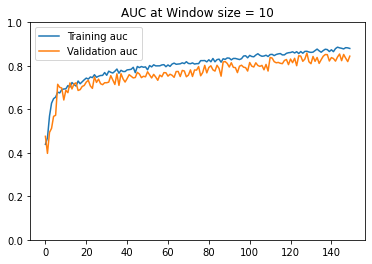

In [12]:
plt.plot(history.history['auc'], label='Training auc')
plt.plot(history.history['val_auc'], label='Validation auc')
plt.ylim([0.0, 1.0])
plt.title('AUC at Window size = 10')
plt.legend()


In [ ]:
#--------------the end------------